# Estimating odometry via dead reckoning

In this notebook we will estimate the state of a vehicle using just odometry (a process known as dead-reckoning). This only uses the IMU as our source of truth. We'll first start with just integration, then add an EKF to see if we can do any better.

We'll use one of the KITTI datasets (a short one) just to get an idea of how this works.

In [24]:
import glob
import os
from datetime import datetime


import numpy as np
import pandas as pd
from scipy.spatial.transform import Rotation as R

In [51]:
DATASET_LOCATION = "/media/saad/95237699-a090-4f1e-979d-e7bfa9412afc/datasets/kitti/2011_09_26"
DATASET_FILES = os.path.join(DATASET_LOCATION, "2011_09_26_drive_0001_sync/oxts/data/*.txt")
files = sorted(glob.glob(DATASET_FILES))

data = np.array([np.loadtxt(f) for f in files])




# Load timestamps
ts = []
with open(
    os.path.join(DATASET_LOCATION, "2011_09_26_drive_0001_sync/oxts/timestamps.txt")
) as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        if "." in line:
            head, frac = line.split(".")
            frac = frac[:6]  # keep microseconds
            line = f"{head}.{frac}"

        ts.append(
            datetime.strptime(line, "%Y-%m-%d %H:%M:%S.%f").timestamp()
        )

ts = np.array(ts)


## Defining our state

We want to estimate the state of the vehicle. We define the state as:

$$\bf{x} = \begin{bmatrix}x\\y\\\phi\\v\end{bmatrix}$$

where $(x, y)$ = xy position, $\phi$ = heading, and $v$ = velocity.

We do make a few assumptions, since KITTI is just a vehicle on a planar surface.

* Vehicle is on flat ground (z = 0)
* Roll/pitch = 0
* Lateral acceleration is only used (to estimate yaw)
* Gravity ignored
* Motion is constrained to body x-axis

What data do we use?

$\omega_z$ = yaw rate

$a_x$ = longitudinal acceleration

Why don't we use lateral acceleration $a_y$? We don't model it for SE(2) state estimators. This is because if we do try and model it, we're essentially saying the car can slide sideways, which is not something we know happens. We can use lateral acceleration as a check, or for bias estimation, which we'll discuss later.

In [52]:
yaw = data[:, 5]
v   = data[:, 8]
ax  = data[:, 11]
wz  = data[:, 19]

In [53]:
# Initial state

x, y = 0.0, 0.0
psi = yaw[0]
v_est = v[0]

Let's define our discete-time motion model:

### Yaw Integration

$$\phi_{k+1} = \phi_k + \omega_{z,k} \Delta t_k$$

## Velocity integration

$$v_{k+1} = v_k + a_{x,k} \Delta t_k$$

## Position integration

Project the motion into the world frame:

$$x_{k+1} = x_k + v_k \cos(\phi_k) \Delta t_k$$

$$y_{k+1} = y_k + v_k \sin(\phi_k) \Delta t_k$$

In [54]:
def position_simple(ts, wz, ax, v_est, psi, x=0.0, y=0.0):
    x_est, y_est = [], []
    for i in range(len(ts) - 1):
        dt = ts[i+1] - ts[i]
    
        psi += wz[i] * dt
        v_est += ax[i] * dt
    
        x += v_est * np.cos(psi) * dt
        y += v_est * np.sin(psi) * dt
    
        x_est.append(x)
        y_est.append(y)

    return x_est, y_est

# Ground truth

We get ground truth from GPS. Let's load that in.

In [55]:
import pyproj

proj = pyproj.Proj(proj="utm", zone=32, ellps="WGS84")

xs, ys = [], []
for lat, lon in data[:, :2]:
    x, y = proj(lon, lat)
    xs.append(x)
    ys.append(y)

xs = np.array(xs)
ys = np.array(ys)

# Make relative to start
xs -= xs[0]
ys -= ys[0]

## Plotting

Let's plot this out.

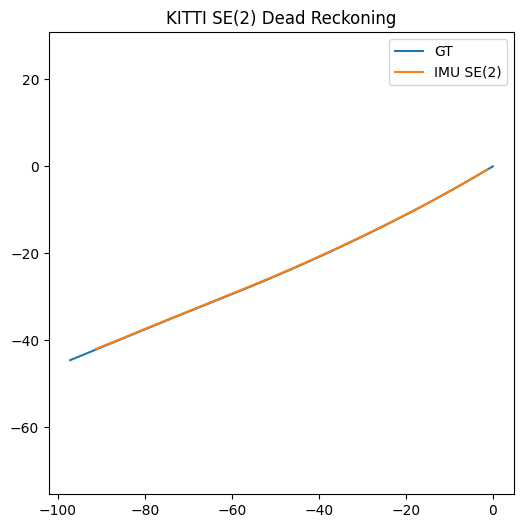

In [56]:
import matplotlib.pyplot as plt

x_est, y_est = position_simple(ts, wz, ax, v_est, psi)

plt.figure(figsize=(6,6))
plt.plot(xs, ys, label="GT")
plt.plot(x_est, y_est, label="IMU SE(2)")
plt.axis("equal")
plt.legend()
plt.title("KITTI SE(2) Dead Reckoning")
plt.show()

This looks pretty good! But it's a fairly straight trajectory. Let's try with something a little more complex.

# Dataset 9

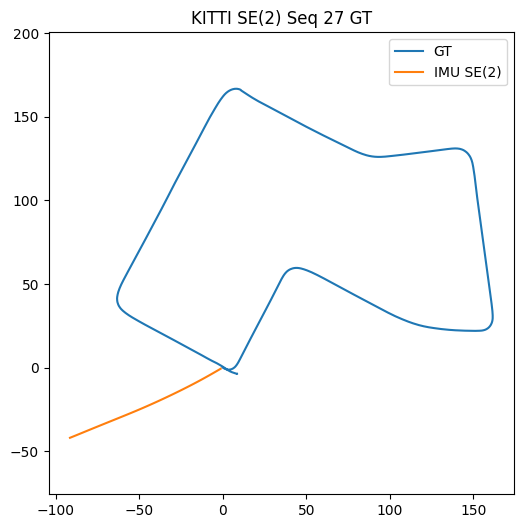

In [57]:
DATASET_LOCATION = "/media/saad/95237699-a090-4f1e-979d-e7bfa9412afc/datasets/kitti/2011_09_30"
DATASET_FILES = os.path.join(DATASET_LOCATION, "2011_09_30_drive_0027_sync/oxts/data/*.txt")
files = sorted(glob.glob(DATASET_FILES))

data = np.array([np.loadtxt(f) for f in files])




# Load timestamps
ts = []
with open(
    os.path.join(DATASET_LOCATION, "2011_09_30_drive_0027_sync/oxts/timestamps.txt")
) as f:
    for line in f:
        line = line.strip()
        if not line:
            continue

        if "." in line:
            head, frac = line.split(".")
            frac = frac[:6]  # keep microseconds
            line = f"{head}.{frac}"

        ts.append(
            datetime.strptime(line, "%Y-%m-%d %H:%M:%S.%f").timestamp()
        )

ts = np.array(ts)

proj = pyproj.Proj(proj="utm", zone=32, ellps="WGS84")

xs, ys = [], []
for lat, lon in data[:, :2]:
    x, y = proj(lon, lat)
    xs.append(x)
    ys.append(y)

xs = np.array(xs)
ys = np.array(ys)

# Make relative to start
xs -= xs[0]
ys -= ys[0]

yaw = data[:, 5]
v   = data[:, 8]
ax  = data[:, 11]
wz  = data[:, 19]


plt.figure(figsize=(6,6))
plt.plot(xs, ys, label="GT")
plt.plot(x_est, y_est, label="IMU SE(2)")
plt.axis("equal")
plt.legend()
plt.title("KITTI SE(2) Seq 27 GT")
plt.show()

<Figure size 640x480 with 0 Axes>

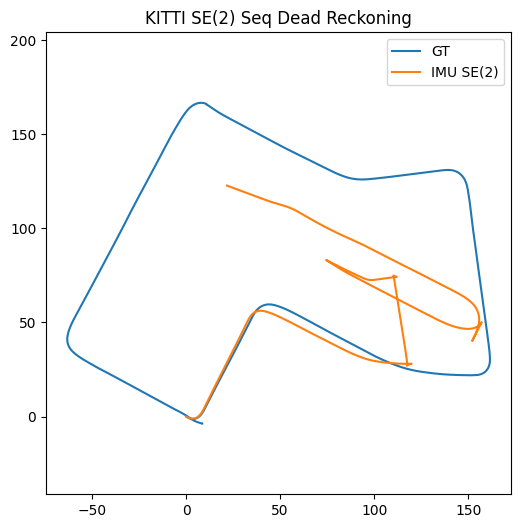

In [58]:
x, y = 0.0, 0.0
psi = yaw[0]
v_est = v[0]

x_est, y_est = position_simple(ts, wz, ax, v_est, psi)

plt.clf()
plt.figure(figsize=(6,6))
plt.plot(xs, ys, label="GT")
plt.plot(x_est, y_est, label="IMU SE(2)")
plt.axis("equal")
plt.legend()
plt.title("KITTI SE(2) Seq Dead Reckoning")
plt.show()

Now we see that the trajectory gets a lot worse! That's because the estimator drifts over time, due to accelerometer and gyro noise. Because the IMU also has biases, this will give us slightly incorrect measurement readings, which when integrated with time, will grow quadratically.

In the next notebook, we'll try to correct some of these with an Extended Kalman Filter, which expands our state and tries to correct for some of these issues with additional estimators.
